<a href="https://colab.research.google.com/github/digre5/Notebooks/blob/main/REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
import sys
import torch
from torch import nn
from torch import optim

The policy is approximated by a Neural Network composed of 2 hidden layers with a parametric number of neurons (i.e. `num_neurons`).

In [ ]:
class PolicyApproximator():
    def __init__(self, n_inputs, n_outputs, num_neurons):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Define network
        self.network = nn.Sequential(
            nn.Linear(self.n_inputs, num_neurons),
            nn.ReLU(),
            nn.Linear(num_neurons, self.n_outputs),
            nn.Softmax(dim=-1))

    def predict(self, state):
        action_probs = self.network(torch.FloatTensor(state))
        return action_probs


In [ ]:
class REINFORCE():

    def __init__(self, env, policy, batch_size, gamma, lr, render_freq=None):

      self.env = env
      self.policy = policy
      self.batch_size = batch_size
      self.gamma = gamma
      self.lr = lr
      self.render_freq = render_freq

      # Set up lists to hold results
      self.total_rewards = []
      self.batch_rewards = []
      self.batch_actions = []
      self.batch_states = []
      self.batch_counter = 1

      # Define optimizer
      self.optimizer = optim.Adam(self.policy.network.parameters(),lr=self.lr)

      self.action_space = np.arange(self.env.action_space.n)

    def discount_rewards(self, rewards):
      r = np.array([self.gamma**i * rewards[i]
          for i in range(len(rewards))])
      # Reverse the array direction for cumsum and then
      # revert back to the original order
      r = r[::-1].cumsum()[::-1]
      return r - r.mean()

    def predict(self,state):
      #print(self.policy.predict(state).detach().numpy())
      action = np.argmax(self.policy.predict(state).detach().numpy())
      return action

    def learn(self,num_episodes, verbose=True):
      ep = 0
      avg_rewards = []
      while ep < num_episodes:
          s_0 = self.env.reset()
          states = []
          rewards = []
          actions = []
          done = False
          while done == False:
              # Get actions and convert to numpy array
              action_probs = self.policy.predict(s_0).detach().numpy()
              action = np.random.choice(self.action_space, p=action_probs)
              s_1, r, done, _ = self.env.step(action)

              if self.render_freq is not None:
                if ep % self.render_freq == 0:
                  self.env.render()

              states.append(s_0)
              rewards.append(r)
              actions.append(action)
              s_0 = s_1

              # If the episode has ended, add the trajectories to the batch
              if done:
                  self.batch_rewards.extend(self.discount_rewards(rewards))
                  self.batch_states.extend(states)
                  self.batch_actions.extend(actions)
                  self.batch_counter += 1
                  self.total_rewards.append(sum(rewards))

                  # If the batch is full, update the network
                  if self.batch_counter == self.batch_size:
                      self.optimizer.zero_grad()
                      state_tensor = torch.FloatTensor(self.batch_states)
                      reward_tensor = torch.FloatTensor( self.batch_rewards)

                      # Actions are used as indices
                      action_tensor = torch.LongTensor(self.batch_actions)

                      # Calculate loss
                      logprob = torch.log(self.policy.predict(state_tensor))
                      selected_logprobs = reward_tensor * torch.gather(logprob, 1, action_tensor.unsqueeze(1)).squeeze()
                      loss = -selected_logprobs.mean()

                      # Calculate gradients
                      loss.backward()
                      # Apply gradients
                      self.optimizer.step()

                      self.batch_rewards = []
                      self.batch_actions = []
                      self.batch_states = []
                      self.batch_counter = 1

                  avg_rewards.append(np.mean(self.total_rewards[-100:]))

                  # Print running average
                  if verbose:
                    print(f"\rEp {ep+1} - Average reward of last 100 episodes: {avg_rewards[-1]} ", end="")

                  ep += 1

      return avg_rewards


# EXERCISE

Find the correct values of `num_neurons`, `batch_size`, `gamma`, `lr`, `num_episodes` (replace the `None` values).
For the CartPole-v0 the target is to abtain an average reward of last 100 episodes close to 200.
If you achieve the goal try another environment from [Gym](https://https://www.gymlibrary.dev/environments/classic_control/).


In [ ]:

# Environment
env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Policy Network
policy = PolicyApproximator(
    n_inputs = obs_dim,
    n_outputs = action_dim,
    num_neurons = None
    )

# Agent Algoritm
agent = REINFORCE(
    env = env,
    policy = policy,
    batch_size = None,
    gamma = None,
    lr = None
)

avg_rewards = agent.learn(num_episodes=None)


/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Ep 1000 - Average reward of last 100 episodes: 425.81 

**For rendering**  *you need to: (1) create a file "reinforce.py" in you computer; (2) copy and paste the code inside the file; (3) add the parameter "render_freq" to the instace of REINFORCE class and set an integer value grather than 0; (4) run the script from terminal as "python reinfroce.py"*

## Results


### Training Results
We plot the returns per episode to show the improvement of the agent across the training, this is a useful way to evaluate the training performances of the agent and compare different hyperparametrs configurations. Since returns are often noisy, a common practice is to show also a smoothed curve (in this case we used the moving average over the last 100 episodes)}

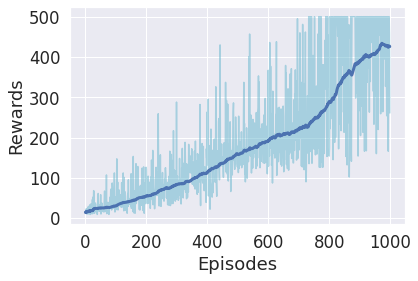

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(agent.total_rewards, "-c", alpha=0.5)
plt.plot(avg_rewards, linewidth=3)

plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.show()

### Testing Results
In a test phase we can assume that the exploration is concluded and we make the policy deterministic by taking always the action with the highest probability (exploitation).  A simple method for evaluating the agent after the training is to get the mean value and the standard deviation of the the returns over $n$ episodes.

In [ ]:
ep_horizon = 500
num_episodes = 1000

obs = env.reset()
returns = []

for ep in range(num_episodes):
  ret = 0
  for t in range(ep_horizon):
    action = agent.predict(obs)
    obs, reward, done, info = env.step(action)
    if done:
      returns.append(ret)
      break
    else:
      ret += 1
  #print(f"\rTest: Ep.{ep} - return={ret}", end="")
  obs = env.reset()


print(f"\n\nMean = {np.mean(returns)}, Std = {np.std(returns)}")



Mean = 477.051, Std = 49.687889862621454


# Reproducibility Issue

Notice that multiple trainings of the same agent (with the same hyperparamters) produce [different results](https://openlab-flowers.inria.fr/t/how-many-random-seeds-should-i-use-statistical-power-analysis-in-deep-reinforcement-learning-experiments/457), clearly this makes difficult to understand whether a configuration of parameters is better than another.


Ep 32 - Average reward of last 100 episodes: 19.375 

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Ep 1000 - Average reward of last 100 episodes: 406.23 

Text(0, 0.5, 'Rewards')

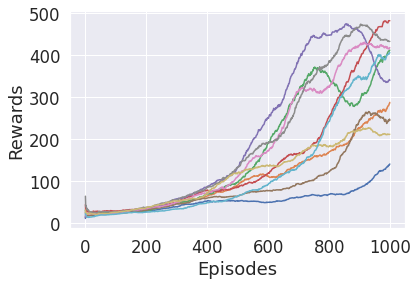

In [ ]:

env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

num_seeds = 10

plt.figure()
for i in range(num_seeds):
  policy = PolicyApproximator(n_inputs = obs_dim, n_outputs = action_dim, num_neurons = None)
  agent = REINFORCE(env = env, policy = policy,  batch_size = None, gamma = None, lr = None)
  avg_rewards = agent.learn(num_episodes = 1000)
  plt.plot(avg_rewards)

plt.xlabel('Episodes')
plt.ylabel('Rewards')

### Random Seed

This great variability in the trainings is the due to high sensitivity to the [seed](https://en.wikipedia.org/wiki/Random_seed) used to initialize the pseudorandom number generator. In fact, by fixing the seed to any value, we obtain always the same solution

In [ ]:
print("Different seed:")

np.random.seed(1)
print("seed=1", np.random.rand(5))

np.random.seed(2)
print("seed=2", np.random.rand(5))

print("Same seed:")

np.random.seed(3)
print("seed=3", np.random.rand(5))

np.random.seed(3)
print("seed=3", np.random.rand(5))

Different seed:
seed=1 [4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01]
seed=2 [0.4359949  0.02592623 0.54966248 0.43532239 0.4203678 ]
Same seed:
seed=3 [0.5507979  0.70814782 0.29090474 0.51082761 0.89294695]
seed=3 [0.5507979  0.70814782 0.29090474 0.51082761 0.89294695]


### Statistical Analysis
We consider the average return per episode over multiple trainings with the same hyper-parameters but using different random seeds


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

num_episodes = 1000
num_seeds = 10

# Hyperparamters configuration n.1
config1_rewards = []
for i in range(num_seeds):
    policy = PolicyApproximator(n_inputs = obs_dim, n_outputs = action_dim, num_neurons = None)
    agent = REINFORCE(env = env, policy = policy,  batch_size = None, gamma = None, lr = None)
    agent_rewards = agent.learn(num_episodes)
    config1_rewards.append(agent_rewards)

# Hyperparamters configuration n.2
config2_rewards = []
for i in range(num_seeds):
    policy = PolicyApproximator(n_inputs = obs_dim, n_outputs = action_dim, num_neurons = None)
    agent = REINFORCE(env = env, policy = policy,  batch_size = None, gamma = None, lr = None)
    agent_rewards = agent.learn(num_episodes)
    config2_rewards.append(agent_rewards)


Ep 1000 - Average reward of last 100 episodes: 68.36 

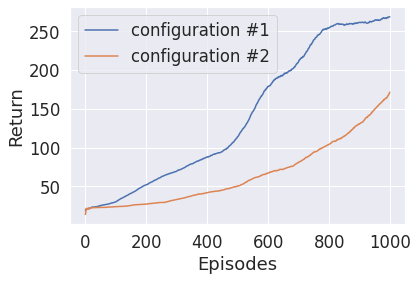

In [ ]:
# Configuration n.1
mean_config1_rewards = np.mean(config1_rewards, axis=0)
plt.plot(mean_config1_rewards, label='configuration #1')

# Configuration n.2
mean_config2_rewards = np.mean(config2_rewards, axis=0)
plt.plot(mean_config2_rewards,  label='configuration #2' )

###
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.legend(loc="upper left")



#### **Seaborn** and **Pandas** libraries


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

env = gym.make('CartPole-v1')
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

num_episodes = 1000
num_seeds = 10

def smooth(values, weight=0.9):
    smoothed = np.array(values)
    for i in range(1, smoothed.shape[0]):
        smoothed[i] = smoothed[i-1] * weight + (1 - weight) * smoothed[i]
    return smoothed

# Hyperparamters configuration n.1
df1 = pd.DataFrame()
for i in range(num_seeds):
    policy = PolicyApproximator(n_inputs = obs_dim, n_outputs = action_dim, num_neurons = 16)
    agent = REINFORCE(env = env, policy = policy,  batch_size = 10, gamma = 0.9, lr = 0.03)
    agent.learn(num_episodes )
    dfi = pd.DataFrame(dict(
        episodes = range(num_episodes),
        rewards = smooth(agent.total_rewards))
    )
    dfi["trainings"] = [i]*num_episodes
    df1 = pd.concat([df1, dfi], ignore_index=True)

# Hyperparamters configuration n.2
df2 = pd.DataFrame()
for i in range(num_seeds):
    policy = PolicyApproximator(n_inputs = obs_dim, n_outputs = action_dim, num_neurons = 8)
    agent = REINFORCE(env = env, policy = policy,  batch_size = 10, gamma = 0.99, lr = 0.01)
    agent.learn(num_episodes)
    dfi = pd.DataFrame(dict(
        episodes = range(num_episodes),
        rewards = smooth(agent.total_rewards))
    )
    dfi["trainings"] = [i]*num_episodes
    df2 = pd.concat([df2, dfi], ignore_index=True)



/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Ep 1000 - Average reward of last 100 episodes: 106.62 

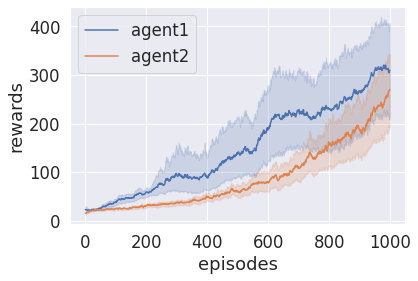

In [ ]:

# Plot results
plt.figure()
sns.set(style="darkgrid", font_scale=1.5)

sns.lineplot(
      data = df1,
      x="episodes",
      y="rewards",
      label='agent1'
)
sns.lineplot(
      data = df2,
      x="episodes",
      y="rewards",
      label='agent2'

)

plt.show()